
# Convolutional Neural Network (CNN) Image Classifier for Persian Numbers 

Due to privacy issues, the CNN model is applied to SVHN dataset here. <br>
Same model can be trained for a dataset including Persian numbers
[SVHN dataset](http://ufldl.stanford.edu/housenumbers/)

Reference:
* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.


In [39]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras import regularizers
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.initializers import he_uniform, glorot_normal, zeros, ones
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [40]:
# loading dataset
# dictionaries with keys `X` and `y` for the input images and labels respectively.
train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

## Visualization fucntions

In [41]:
def show_images(n,image_array,label_array, cmap=None):
    '''
    show random n number of images from image_array with corresponding label_array
    '''
    total_rows = math.floor(n/4)+1
    random_list = random.sample(range(0, image_array.shape[0]), n)
    fig, axes = plt.subplots(total_rows, 4, figsize=(16, total_rows*4))
    [axi.set_axis_off() for axi in axes.ravel()] # this line sets all axis off
    r = 0
    c = 0
    for i in random_list:
        image = image_array[i,:,:,:]
        #axes[r, c].set_axis_off()
        axes[r, c].imshow(np.squeeze(image), cmap=cmap)
        axes[r, c].set_title(f"Label: {label_array[i]} \n {i}th image in the dataset.")
        c += 1
        if c % 4 == 0:
            r += 1
            c = 0
    plt.show()

In [42]:
def show_images_predictions(n,image_array,label_array1,label_array2, cmap=None):
    '''
    show random n number of images from image_array with corresponding label_array
    the precition of class probablity distibution from each model also would be discplayed
    '''
    random_list = random.sample(range(0, image_array.shape[0]), n)
    fig, axes = plt.subplots(n, 2, figsize=(16, n*6))
    #[axi.set_axis_off() for axi in axes.ravel()] # this line sets all axis off
    category_list1 = list(map(lambda x : x + 0.15, list(range(10)))) 
    category_list2 = list(map(lambda x : x - 0.15, list(range(10)))) 
    r = 0
    for i in random_list:
        image = image_array[i,:,:,:]
        axes[r, 0].set_axis_off()
        axes[r, 0].imshow(np.squeeze(image), cmap=cmap)
        #axes[r, 1].set_title(f"{i}th image in the dataset.")
        axes[r, 1].bar(category_list1,label_array1[i], width=0.3, label='MLP')
        axes[r, 1].bar(category_list2,label_array2[i], width=0.3, label='CNN')
        axes[r, 1].set_title(f"Prediction from MLP model: {np.argmax(label_array1[i,:])} \n Prediction from CNN model: {np.argmax(label_array2[i,:])} ")
        axes[r, 1].legend()
        r += 1
    plt.show()

In [53]:
# Functions to plot accuacy and loss
def plot_acc(history):
    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except KeyError:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show() 


def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show() 

## Preprocessing

In [43]:
train_images = train['X'] 
train_labels = train['y']
test_images = test['X'] 
test_labels = test['y']

# scaling the numbers
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshaping the inputs
train_images = np.moveaxis(train_images,-1,0)
test_images = np.moveaxis(test_images,-1,0)

# changing 0 number label from 10 to 0
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0

In [44]:
train_images_grey = np.mean(train_images, axis=3)
train_images_grey = np.expand_dims(train_images_grey, axis=3) # add the channel dimension
test_images_grey = np.mean(test_images, axis=3)
test_images_grey = np.expand_dims(test_images_grey, axis=3) # add the channel dimension

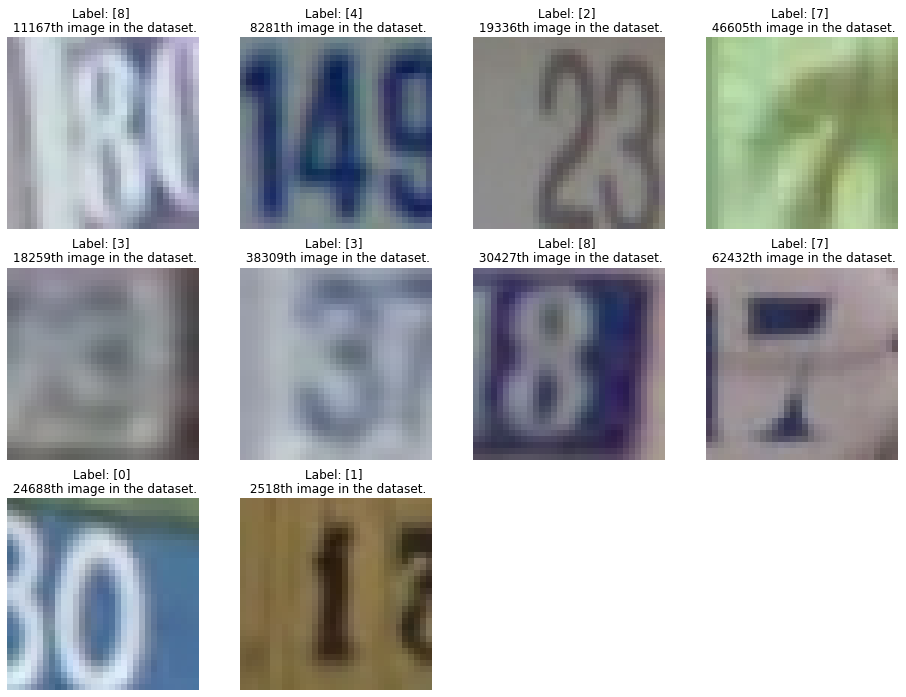

In [45]:
n = 10 # number of images to show
# showing images and correspoind labels from train set
show_images(n,train_images,train_labels)

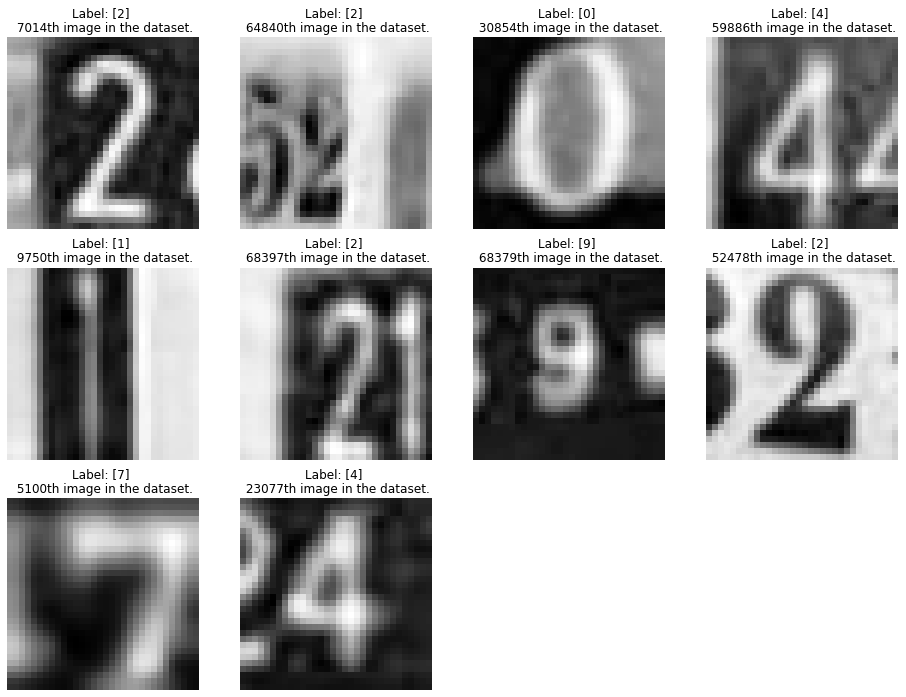

In [46]:
n = 10 # number of images to show
# showing greay images and correspoind labels from train set
show_images(n,train_images_grey,train_labels, cmap='Greys')

## CNN neural network classifier

In [47]:

def CNN_NN(input_shape, dropout_rate, reg_rate):
    model = Sequential([
        Conv2D(8, (3,3), activation='relu', input_shape=input_shape, 
               kernel_initializer="he_uniform", bias_initializer="ones", 
               kernel_regularizer=regularizers.l2(reg_rate), name='CONV2D_1_1_relu'),
        BatchNormalization(),
        Conv2D(16, (3,3), activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='CONV2D_2_2_relu'),
        MaxPool2D((3,3), strides=(2, 2), name='MaxPool2D_1_2_relu'),
        Dropout(dropout_rate),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='CONV2D_3_3_relu'),
        MaxPool2D((3,3), strides=(2, 2), name='MaxPool2D_2_3_relu'),
        Dropout(dropout_rate),
        BatchNormalization(),
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='Dense_1_4_relu'),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='Dense_2_5_relu'),
        Dense(10, activation='softmax', name='Dense_3_6_softmax')
    ])
    return model

In [48]:
# creating CNN model for greay scale images
model_CNN = CNN_NN(input_shape= (32,32,1), dropout_rate = 0.3, reg_rate=1e-3)
model_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV2D_1_1_relu (Conv2D)     (None, 30, 30, 8)         80        
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 30, 8)         32        
_________________________________________________________________
CONV2D_2_2_relu (Conv2D)     (None, 28, 28, 16)        1168      
_________________________________________________________________
MaxPool2D_1_2_relu (MaxPooli (None, 13, 13, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 16)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 13, 13, 16)        64        
_________________________________________________________________
CONV2D_3_3_relu (Conv2D)     (None, 11, 11, 32)       

In [49]:
model_CNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
checkpoint_best_only = get_checkpoint_best_only('Trained models weights\checkpoints_best_only_CNN\checkpoint')

history_CNN = model_CNN.fit(train_images_grey,
                            train_labels,
                            batch_size=32,
                            epochs=30,
                            validation_split=0.10,
                            callbacks=[EarlyStopping(monitor='val_accuracy', patience=4), checkpoint_best_only]
                           )

Epoch 1/30
2060/2061 [============================>.] - ETA: 0s - loss: 1.0438 - accuracy: 0.7239
Epoch 00001: val_accuracy improved from -inf to 0.84794, saving model to Trained models weights\checkpoints_best_only_CNN\checkpoint
2061/2061 [==============================] - 89s 43ms/step - loss: 1.0437 - accuracy: 0.7239 - val_loss: 0.6759 - val_accuracy: 0.8479
Epoch 2/30
2061/2061 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.8370
Epoch 00002: val_accuracy improved from 0.84794 to 0.87073, saving model to Trained models weights\checkpoints_best_only_CNN\checkpoint
2061/2061 [==============================] - 91s 44ms/step - loss: 0.6942 - accuracy: 0.8370 - val_loss: 0.5856 - val_accuracy: 0.8707
Epoch 3/30
2059/2061 [============================>.] - ETA: 0s - loss: 0.6309 - accuracy: 0.8546
Epoch 00003: val_accuracy improved from 0.87073 to 0.88438, saving model to Trained models weights\checkpoints_best_only_CNN\checkpoint
2061/2061 [====================

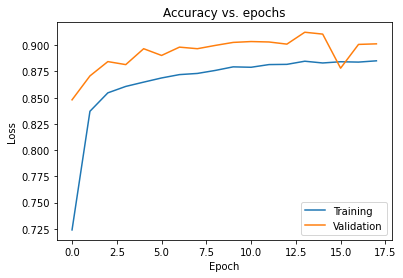

In [54]:
plot_acc(history_CNN)

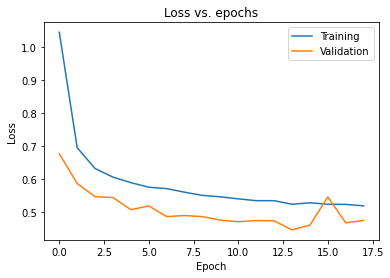

In [55]:
plot_loss(history_CNN)

In [56]:
get_test_accuracy(model_CNN, test_images_grey, test_labels)

 test accuracy: 0.898 
 test loss: 0.490


## Model predictions

In [57]:
def get_model_best_epoch(model, checkpoint_path):
    '''
    get model saved best epoch
    '''
    model.load_weights(checkpoint_path)
    
    return model

In [58]:
# CNN model best epoch
model_CNN = CNN_NN(input_shape= (32,32,1), dropout_rate = 0.3, reg_rate=1e-4)
model_CNN = get_model_best_epoch(model_CNN, 'Trained models weights\checkpoints_best_only_CNN\checkpoint')

In [59]:
prediction_CNN = model_CNN.predict(test_images_grey)
prediction_CNN_final = np.argmax(prediction_CNN, axis=1) # finding the maximum category
prediction_CNN_final = np.expand_dims(prediction_CNN_final, axis=1) # add the channel dimension

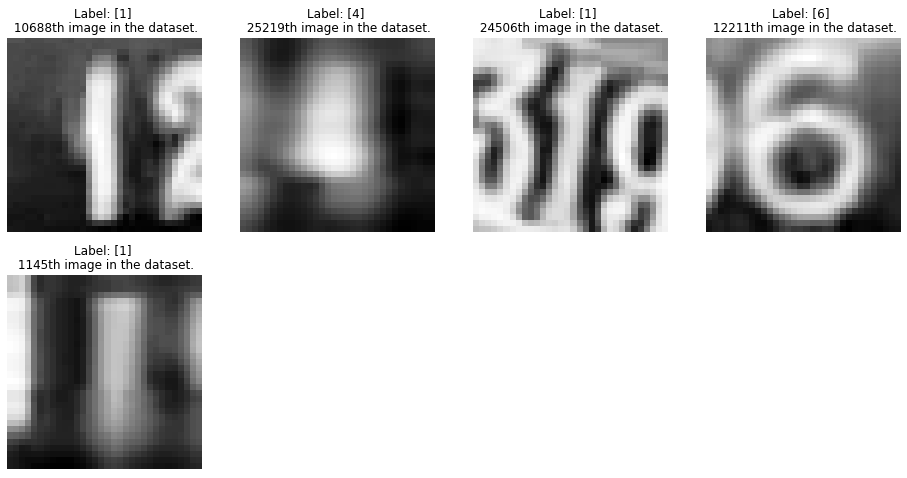

In [64]:
n = 5 # number of images to show
show_images(n,test_images_grey,prediction_CNN_final, cmap='Greys')

## Comparison
To do a comparison between MLP and CNN model, the MLP model is created here and the trained wights are loaded

In [65]:
def MLP_NN(input_shape, reg_rate):
    '''
    Multilayer Perceptron (MLP) classification model
    '''
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(256, activation='relu', kernel_initializer="he_uniform", bias_initializer="ones",
              kernel_regularizer=regularizers.l2(reg_rate), name='dense_1_relu'),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='dense_2_relu'),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='dense_3_relu'),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='dense_4_relu'),
        Dense(10, activation='softmax', name='dense_5_softmax')
    ])
    return model

model_MLP = MLP_NN(input_shape=(32,32,1), reg_rate=1e-4)
model_MLP = get_model_best_epoch(model_MLP, 'Trained models weights\checkpoints_best_only_MLP\checkpoint')
prediction_MLP = model_MLP.predict(test_images_grey)
prediction_MLP_final = np.argmax(prediction_MLP, axis=1) # finding the maximum category
prediction_MLP_final = np.expand_dims(prediction_MLP_final, axis=1) # add the channel dimension

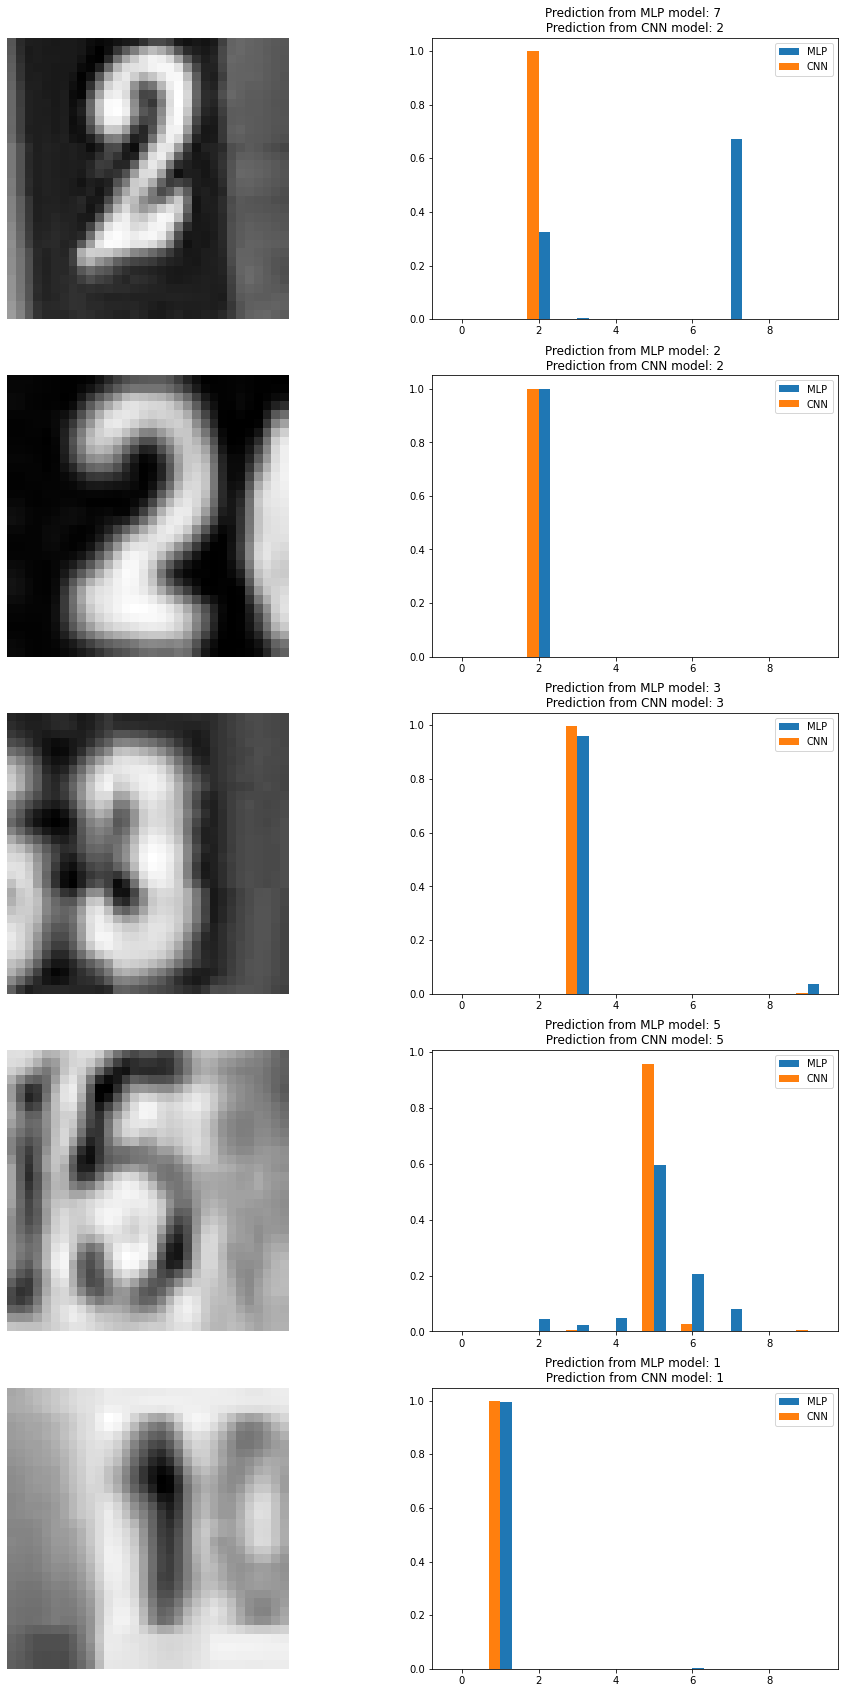

In [66]:
n = 5 # number of random images
show_images_predictions(n,test_images_grey,prediction_MLP, prediction_CNN, cmap='Greys')